In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from importlib import reload
import PIVutils

In [76]:
#PIVutils = reload(PIVutils)
X, Y, U, V, Swirl, Cond, Prof = PIVutils.importMatlabPIVdata2D('/Users/Owen/Dropbox/Data/ABL/SBL PIV data/RNV45-RI2.mat',['X','Y','U','V','Swirl'],['Cond','Prof'])

In [77]:
NanLocs = np.isnan(Swirl)
uSize = Swirl.shape
scale = (X[1,-1]-X[1,1])/(uSize[1]-1)

# Normalize field by std

In [78]:
SwirlStd = np.std(np.nanmean(Swirl,axis=2),axis = 1)

In [79]:
#Normalize field by the std of Swirl
SwirlNorm = Swirl/SwirlStd.reshape(uSize[0],1,1) #match the SwirlStd length (123) with the correct index in Swirl (also 123)

# Create thresholded field

In [84]:
SwirlFilt = Swirl.copy()    #think this should completely copy the list, allowing me to try things

#Swirl must be above a certain background value or it is zeroed
SwirlFilt[np.absolute(SwirlFilt)<7] = 0

#Then only keep those locations where swirls is greater than Thresh*SwirlStd
ThreshSTD = 60
SwirlFilt[np.absolute(SwirlNorm)<ThreshSTD] = 0

# Find all blobs and filter for size


In [85]:
PIVutils = reload(PIVutils)
Thresh = 50
[num_features,features_per_frame, labeled_array, cent] = PIVutils.findBlobs(SwirlFilt,50)

There are  55342  features identified
A total of  2638  are larger than the threshold size


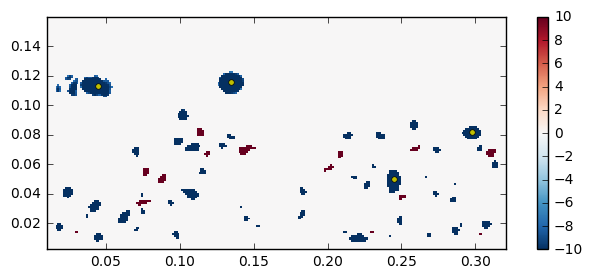

In [158]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(SwirlFilt[:,:,1],X,Y,10)

for i in range(features_per_frame[1]):
    plt.plot(cent[1][i][1]*scale+X[1,1],cent[1][i][0]*scale+Y[1,1],'oy',markersize=4,markeredgecolor=None)

# Subtract mean profile or mean at centroid of swirl blob

In [88]:
#Calculate mean velocity profiles
Umean = np.nanmean(np.nanmean(U,axis=2),axis = 1)
Umean
Umean.shape
#print(Umean)

Umean = np.transpose(np.tile(Umean,(uSize[2],uSize[1],1)),(2,1,0))
#print(Umean.shape)

#Subtract mean velocity profiles from velocity fields
Uf = U - Umean;
Vf = V; #<--Mean in vertical is aprox zero
#Wf = W
del Umean

# Find all thumbnails

In [249]:
BoxSize = 20     #turns out to half size of final box (box is 21 per side of BoxSize = 10)

Ut = np.zeros([2*BoxSize+1,2*BoxSize+1,num_features])    #initialize thumbnail matrices
Ut[:] = np.NAN
Vt = Ut.copy()
St = Ut.copy()
print(Ut.shape)


(41, 41, 2638)


In [250]:
#pad out velocity fields so that there are NaNs around in all directions
Uf2 = np.zeros([uSize[0]+2*BoxSize,uSize[1]+2*BoxSize,uSize[2]])    
Uf2[:] = np.NAN
Vf2 = Uf2.copy()
Sf2 = Uf2.copy()

print(Uf.shape)
print(Uf2.shape)

Uf2[BoxSize:-1*BoxSize,BoxSize:-1*BoxSize,:] = Uf.copy()
Vf2[BoxSize:-1*BoxSize,BoxSize:-1*BoxSize,:] = Vf.copy()
Sf2[BoxSize:-1*BoxSize,BoxSize:-1*BoxSize,:] = SwirlFilt.copy()

(123, 242, 750)
(163, 282, 750)


In [251]:
print(range(len(cent)))
print(np.sum(features_per_frame))

range(0, 750)
2638


In [252]:
#Round all centroids to integers
for i in range(len(cent)):
    for j in range(len(cent[i])):
        #print(i, j)
        cent[i][j] = (int(round(cent[i][j][0])), int(round(cent[i][j][1])))

/Users/Owen/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


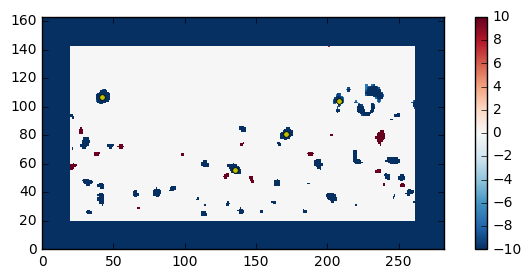

In [253]:
# Just to check, plot the new masked matrix to ensure its what we think it is. 
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(Sf2[:,:,0],bound=10)

for i in range(features_per_frame[1]):
    plt.plot(cent[0][i][1]+BoxSize,cent[0][i][0]+BoxSize,'oy',markersize=4,markeredgecolor=None)

In [254]:
thumb = 0
for i in range(len(cent)):
    for j in range(len(cent[i])):
        
        Ut[:,:,thumb] = Uf2[cent[i][j][0]:cent[i][j][0]+2*BoxSize+1,cent[i][j][1]:cent[i][j][1]+2*BoxSize+1,i]  
        #print(cent[i][j][0])
        Vt[:,:,thumb] = Vf2[cent[i][j][0]:cent[i][j][0]+2*BoxSize+1,cent[i][j][1]:cent[i][j][1]+2*BoxSize+1,i] 
        St[:,:,thumb] = Sf2[cent[i][j][0]:cent[i][j][0]+2*BoxSize+1,cent[i][j][1]:cent[i][j][1]+2*BoxSize+1,i]  
        thumb+=1
        #print(thumb)
    

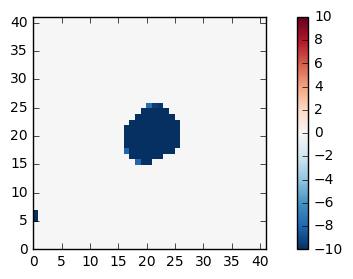

In [255]:
[f, ax] = PIVutils.plotScalarField(St[:,:,0],bound=10)

BoxSize = 20

Ut, Vt = getThumbnails(Uf,Vf,Sf,cent,BoxSize)